<a href="https://colab.research.google.com/github/msamunetogetoge/masamune/blob/master/get_grads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflowの読み込みとMNISTの読み込み

自分のドライブに何かを保存したい時は、初めにdrive.mountする必要があります。必要ない人や、colab を使ってない人は、次のセルを飛ばしてください。

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

keras にMNISTが入っているので、読み込みます。データの並び順は、
(トレーニング画像,トレーニングラベル), (テスト画像,テストラベル)です。




In [11]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print("それぞれのサイズは、トレーニングデータ={}, テストデータ={}, ラベルの形は{}".format(train_images.shape , test_images.shape, train_labels.shape))

それぞれのサイズは、トレーニングデータ=(60000, 28, 28), テストデータ=(10000, 28, 28), ラベルの形は(60000,)


トレーニングでは28×28の画像60000枚、テストでは10000枚の画像が用意されています。
実務でもこのくらいの量の良質なデータが欲しいものです。ラベルはone-hot-encodingされていないようです。必要なら別途しておきましょう。画像を表示してみます。

Text(0.5, 1.0, '5')

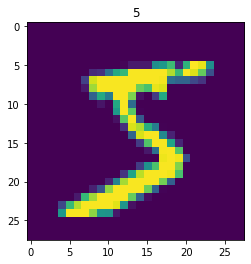

In [12]:
img = train_images[0]
plt.imshow(img)
plt.title(train_labels[0])

トレーニングの1枚目は5でした。画像の中身を一応見ておきます。

In [17]:
img[:,20]

array([  0,   0,   0,   0,   0, 166, 253,  82,   0,   0,   0,   0,   0,
         0,   0,   0,   0,  64,   2,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=uint8)

次に、画像の前処理を行います。0から255までの整数値を取っているので、255で割って、0から1の間に押し込めます。

In [0]:
train_images = train_images / 255.0
test_images = test_images / 255.0

# モデルの作成と評価

簡単なモデルを作りましょう。keras のSequential は枝分かれの無いモデルを簡単に作る事が出来ます。計算を早く終わらせる為に、畳み込みは使いません。

In [19]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


簡単に解説を書いておきます。
Sequential([layer1,layer2, … ])と書きます。
Flatten は、(データの個数, 配列) というデータを受け取って、(データの個数, i次元配列)を返してくれる層です。
Dense は全結合層です。Dense(node, オプション)の形で書きます。個別にbias の初期値を決めたりできます。activation=hoge と書く事で、活性化関数をして出来ます。
今回は入力と出力含めて3層からなる簡単なニューラルネットワークです。
モデルで訓練するべきパラメーターの数や、層についている名前を見る機能があります。

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


モデルを作ったらmodel.compileします。ここでオプティマイザーや損失関数を決めます。また、metrics で、ログに残しておきたい評価値を指定できます。"accuracy" とか"mean_squared_error" の事です。略称の"acc"とか、"mse"とかでも指定できます。今回はオプティマイザーはadam, 損失関数はスパースクロスエントロピーです。

In [0]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

次に、モデルのトレーニングをします。トレーニングは.fit(training_data, training_label, validation_data)で行います。ここで、バッチサイズやエポック数を指定します。学習が上手くいかない時に自動で切り上げたりする、callback もここで指定します。

In [26]:
h=model.fit(train_images, train_labels,
            validation_data=(test_images, test_labels),batch_size=20,
            epochs=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 11s 176us/sample - loss: 0.2418 - acc: 0.9302 - val_loss: 0.1319 - val_acc: 0.9601
Epoch 2/5
60000/60000 [==============================] - 9s 154us/sample - loss: 0.1059 - acc: 0.9678 - val_loss: 0.0926 - val_acc: 0.9712
Epoch 3/5
60000/60000 [==============================] - 9s 154us/sample - loss: 0.0720 - acc: 0.9779 - val_loss: 0.0885 - val_acc: 0.9730
Epoch 4/5
60000/60000 [==============================] - 9s 156us/sample - loss: 0.0533 - acc: 0.9832 - val_loss: 0.0775 - val_acc: 0.9753
Epoch 5/5
60000/60000 [==============================] - 9s 154us/sample - loss: 0.0417 - acc: 0.9870 - val_loss: 0.0785 - val_acc: 0.9764


h の中に、history と言う名前で色々な情報が格納されています。

In [28]:
import pandas as pd
history=pd.DataFrame(h.history)
history.head()

,loss,acc,val_loss,val_acc
0,0.241795,0.930233,0.131928,0.9601
1,0.105884,0.967750,0.092552,0.9712
2,0.071951,0.977867,0.088514,0.9730
3,0.053290,0.983217,0.077534,0.9753
4,0.041675,0.986983,0.078500,0.9764


historyの中身をグラフに描いてモデルを評価することが多いと思います。

Text(0.5, 0, 'Epock')

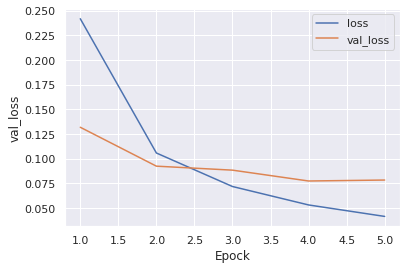

In [33]:
import seaborn as sns
sns.set()
sns.lineplot(x=range(1, len(history)+1), y=history.loss, label="loss")
sns.lineplot(x=range(1, len(history)+1), y=history.val_loss, label="val_loss")
plt.xlabel("Epock")

必要ならモデルの情報を保存しておけます。

In [0]:
model.save("simple_model.h5")

保存してあるモデルはkeras の models.load_model で読み込むことが出来ます。重みだけの情報を保存したり、訓練途中のモデルを保存したりも出来ます。その辺は公式サイトの説明が親切です。[モデルの保存と復元](https://www.tensorflow.org/tutorials/keras/save_and_load?hl=ja)

In [42]:
new_model = keras.models.load_model('simple_model.h5')
pred= new_model.predict(np.expand_dims(test_images[0],0))
pred=np.argmax(pred)
loss, acc = new_model.evaluate(test_images, test_labels)
print("予測値={}, 正解ラベル={}".format(pred, test_labels[0]))
print("正解率={}".format(acc))

10000/10000 [==============================] - 1s 71us/sample - loss: 0.0785 - acc: 0.9764
予測値=7, 正解ラベル=7
正解率=0.9764000177383423


トレーニングしたmodel と保存したのを呼び出したnew_model は同じ性能です。モデルの構築から評価はこんな感じだと思います。次は、勾配の情報を取り出すとか、少し立ち入ってモデルを見たい時にどうするか書いていきます。

# Keras backend function を使う

モデルの途中の値を見たいとか(CNNで画像がどう変わっていくか見たいとか), 勾配の情報を監視したいとか、そんなときがあると思います。
その時は、keras のbackend を使います。
この時、import keras.backend としてしまうとエラーが出て、やりたいことが出来なくなります。最後にエラーが出るコードを載せておきます。 

In [0]:
import tensorflow.keras.backend as K

今回は、heatmap を作る時の手法を使います。model の出力値"5" の勾配情報を取得します。
model.summary で出てくる名前を使って、好きな層の勾配情報を取得できますが、weightとbias それぞれに関する勾配をどうやって取得するのかは良く分かっていません。(教えてください。)


In [0]:
class_output = model.output[:,5]  # Tensor / クラススコア
grad_tensor = K.gradients(class_output, model.input)[0]  # Tensor / クラススコアに対する入力の勾配
grad_func = K.function([model.input], [grad_tensor])  #  勾配の値を算出するための関数
x= np.expand_dims(train_images[0], axis=0)  #画像自体は大きさが(28,28) なので(1,28,28)にする
gradient = grad_func([x])[0][0]  # ndarray: 算出された勾配の値

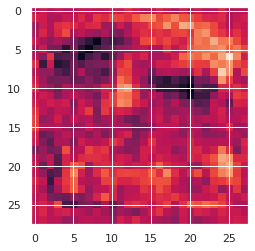

In [129]:
plt.imshow(gradient)

model にはoutput とoutouts がありますが、outputsを使うとエラーが起きます。これは良く分かりません。print して情報を見ると微妙に違うので、そのせいなのでしょう。(教えてください)

In [132]:
print(model.outputs)
print(model.output)
class_output = model.outputs[:,5]  # Tensor / クラススコア
grad_tensor = K.gradients(class_output, model.input)[0]  # Tensor / クラススコアに対する入力の勾配
grad_func = K.function([model.input], [grad_tensor])  # 勾配の値を算出するための関数
gradient = grad_func([x])[0][0]  # ndarray: 算出された勾配の値

[<tf.Tensor 'dense_1/Softmax:0' shape=(?, 10) dtype=float32>]
Tensor("dense_1/Softmax:0", shape=(?, 10), dtype=float32)


TypeError: ignored

# 起こしがちなエラー

勾配を取得するに限らずですが、やってしまいがちなエラーがあります。それは、keras関連のものを import する時にtensorflow. と明示し忘れる事です。勾配取得でこれをやると、エラーが起きますし、色々な所でエラーが起きます。

In [133]:
import keras.backend as K

Using TensorFlow backend.


In [134]:
class_output = model.output[:,5]  # Tensor / クラススコア
grad_tensor = K.gradients(class_output, model.input)[0]  # Tensor / クラススコアに対する入力の勾配
grad_func = K.function([model.input], [grad_tensor])  #  勾配の値を算出するための関数
x= np.expand_dims(train_images[0], axis=0)  #画像自体は大きさが(28,28) なので(1,28,28)にする
gradient = grad_func([x])[0][0]  # ndarray: 算出された勾配の値

FailedPreconditionError: ignored

このエラーで1日溶かしてしまったので、この記事を読んだ人の助けになれば幸いです。